# Key Problem V: Sampling Groups for Comparison
# Propagating Inaccuracies

Here, we demonstrate how to propagate errors from the machine learning classifiers to statistical group comparisons making the conclusions robust to inaccuracies of the classifiers. In our working example, we used non-parametric matching to compare the effect of tweets with different strategies present versus not (e.g. opinion versus no opinion) on subsequent hate. Here, for simplicity, let's assume we would like to investigate whether tweets containing opinions are also less/more hateful than tweets containing no opinion with an independent t-test.

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from scipy.special import softmax
from sklearn.metrics import confusion_matrix
from scipy import stats
import matplotlib.pyplot as plt

/Users/alinaherderich/anaconda3/envs/CSMM-pipeline/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Extract Relevant Variables Using Machine Learning Classifiers

In [2]:
# We'll load a sample corpus of 1000 unlabeled tweets for our example.
sample_corpus = pd.read_csv("data/sample_pool.csv")
sample_corpus = sample_corpus[:1000]
sample_corpus.head()

,tweet_id,text
0,960158527582097408,Das ist so nicht richtig.
1,837717128480444418,Man sollte die Drohungen von der ISIS Gruppe e...
2,1082375206319128576,Gerade gibt's in den USA eine Ausschreibung fü...
3,1013645930443235328,Horst los! Das Netz hat dein Angebot voll ange...
4,1031345564649172992,Und was jetzt? Müssen wir uns jetzt neben dem ...


In [3]:
# Now, we need to classify tweets with opinion versus no opinion (binary variable) and extract a
# hate score for each of the tweets (continuous variable). For no/opinion, let's use our classifier
# from notebook "training on confident examples". For hate, we'll use a pre-trained German BERT from
# Huggingface that was finetuned on a German hate speech dataset
# (see here: https://epub.oeaw.ac.at/0xc1aa5576_0x003a10d2.pdf).
MODEL_STRATEGY = "finetuned_models/twitter-xlm-roberta-base_split-1"
MODEL_HATE = "deepset/bert-base-german-cased-hatespeech-GermEval18Coarse"

In [4]:
def inference(feature="opinion"):
    """
    Runs classifiers specified in MODEL_STRATEGY and MODEL_HATE over
    the sample corpus, respectively.

    Parameter "feature" takes values "opinion" or "hate".
    """
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():  # for Apple Silicon
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    print(f"Using device: {device}")

    if feature == "opinion":
        tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-xlm-roberta-base")
        model = AutoModelForSequenceClassification.from_pretrained(MODEL_STRATEGY).to(device)
    if feature == "hate":
        tokenizer = AutoTokenizer.from_pretrained(MODEL_HATE)
        model = AutoModelForSequenceClassification.from_pretrained(MODEL_HATE).to(device)
    
    preds = []
    
    for t in tqdm(sample_corpus.text.to_list()):
        inputs = tokenizer(t, truncation=True, padding=True, max_length=180, return_tensors="pt").to(device)
    
        with torch.no_grad():
            logits = model(**inputs).logits
    
        if device == "mps":
            torch.mps.empty_cache()

        preds.append(softmax(logits.cpu())[0][1])  # both "opinion" and "hate" correspond to label 1

    return preds

In [5]:
# infer opinion score for tweets and add as column to dataframe
opinion_probs = inference(feature="opinion")
sample_corpus["opinion_probs"] = opinion_probs

Using device: mps


100%|███████████████████████████████████████| 1000/1000 [00:12<00:00, 77.38it/s]


In [6]:
# infer hate score for tweets and add as column to dataframe
hate = inference(feature="hate")
sample_corpus["hate"] = hate

Using device: mps


100%|██████████████████████████████████████| 1000/1000 [00:08<00:00, 118.81it/s]


In [7]:
sample_corpus.head()

,tweet_id,text,opinion_probs,hate
0,960158527582097408,Das ist so nicht richtig.,0.198935,0.088122
1,837717128480444418,Man sollte die Drohungen von der ISIS Gruppe e...,0.195629,0.014237
2,1082375206319128576,Gerade gibt's in den USA eine Ausschreibung fü...,0.191290,0.009567
3,1013645930443235328,Horst los! Das Netz hat dein Angebot voll ange...,0.196171,0.014625
4,1031345564649172992,Und was jetzt? Müssen wir uns jetzt neben dem ...,0.198566,0.008012


## Binarize Opinion Versus No Opinion

In [8]:
# Usually, we would now use our threshold inferred from the data as demonstrated in notebook
# "binarizing classes" to assign tweets to the "opinion" versus "no opinion" class. However,
# since we are working with a (very bad performing) preliminary classifier, for demonstration
# purposes, let's set the cut off score arbitrarily such that approximately half of the tweets
# are assigned to "opinion" and "no opinion".
sample_corpus["opinion_binary"] = np.array(opinion_probs) > 0.221  # arbitrary cut off for demonstration only!
sample_corpus["opinion_binary"] = sample_corpus["opinion_binary"].replace({False: 0, True: 1})
sample_corpus.head()

/var/folders/pr/ww_9n13j1n3b2xg6jrj22hq40000gn/T/ipykernel_36405/338222466.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sample_corpus["opinion_binary"] = sample_corpus["opinion_binary"].replace({False: 0, True: 1})


,tweet_id,text,opinion_probs,hate,opinion_binary
0,960158527582097408,Das ist so nicht richtig.,0.198935,0.088122,0
1,837717128480444418,Man sollte die Drohungen von der ISIS Gruppe e...,0.195629,0.014237,0
2,1082375206319128576,Gerade gibt's in den USA eine Ausschreibung fü...,0.191290,0.009567,0
3,1013645930443235328,Horst los! Das Netz hat dein Angebot voll ange...,0.196171,0.014625,0
4,1031345564649172992,Und was jetzt? Müssen wir uns jetzt neben dem ...,0.198566,0.008012,0


## Calculating False Positive and False Negative Rate

In [9]:
# To calculate the false positive (FPR) and false negative rate (FNR), we will rely on the 
# true and predicted scores for opinion on our test set for the best performing model
# (see notebook "binarizing classes"). We will need the FPR and FNR for bootstrapping
# statistical parameters in the group comparisons later.
testset = pd.read_csv("data/preds_strategy_test/twitter-xlm-roberta-base_epochs-100_batchsize-64_strategy_split-3_preds.csv")
testset = testset[["label", "pred_label"]].rename(columns={"label": "true_label"})
testset.head()

,true_label,pred_label
0,1,1
1,3,3
2,1,3
3,3,1
4,1,1


In [10]:
confusion = confusion_matrix(testset.true_label, testset.pred_label)
confusion

array([[ 26,  19,   0,  11,   6],
       [ 16, 133,   1,  28,   9],
       [ 10,  11,   2,   8,   6],
       [  3,  25,   1, 131,   4],
       [  9,  15,   0,   7, 113]])

In [11]:
TP = confusion[1, 1]
FN = confusion[1, :].sum() - TP
FP = confusion[:, 1].sum() - TP
TN = len(testset) - FN - FN - FP

FPR = FP / (FP + TN)  # 0.14
FNR = FN / (FN + TP)  # 0.29

## Bootstrapping t Statistics

In [12]:
def cohens_d(A, B):
    """
    Calculates Cohen's d as effect size for the t test of independent samples
    A and B with different sample sizes and different variances.
    """
    n1 = len(A)
    n2 = len(B)
    var1 = A.var()
    var2 = B.var()
    mean1 = A.mean()
    mean2 = B.mean()
    
    sd_pooled = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    
    d = (mean1 - mean2) / sd_pooled

    return d

In [13]:
# We will run the t test for a thousand times flipping the label opinion to no opinion based
# on the false positive rate and no opinion to opinion on the false negative rate. We'll collect
# the t statistic and the Cohen's d for each of those runs to plot them afterwards.
BOOT = 1000

summary_t = []
summary_d = []

for i in tqdm(range(BOOT)):
    flip_positive = pd.Series(sample_corpus.index[sample_corpus.opinion_binary == 1]).sample(frac=FPR, random_state=i)
    flip_negative = pd.Series(sample_corpus.index[sample_corpus.opinion_binary == 0]).sample(frac=FNR, random_state=i)
    
    temp = sample_corpus.copy()
    temp.loc[flip_positive, "opinion_binary"] = 0
    temp.loc[flip_negative, "opinion_binary"] = 1

    t, p = stats.ttest_ind(temp[temp.opinion_binary == 0].hate, temp[temp.opinion_binary == 1].hate)
    d = cohens_d(temp[temp.opinion_binary == 0].hate, temp[temp.opinion_binary == 1].hate)

    summary_t.append(t)
    summary_d.append(d)

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 530.05it/s]


Text(0, 0.5, 'frequency')

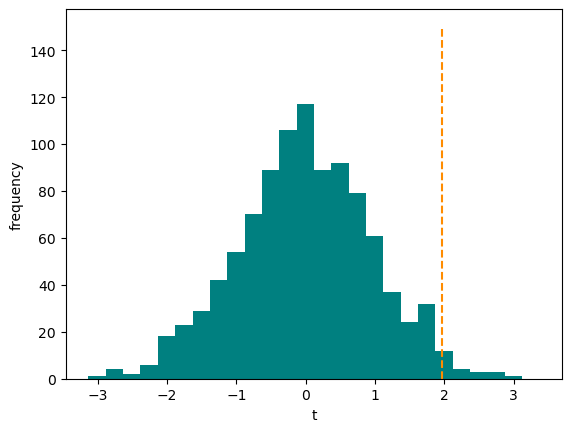

In [14]:
# Histogram of t statistics
# The vertical line denotes the cut of score for an alpha level of 0.05.
# Here, we can make the robust conclusion that the two groups (opinion vs.
# no opinion) differ only when all bootstrapped tests exceed the significance level.
plt.hist(summary_t, bins=np.arange(np.min(summary_t), np.max(summary_t), 0.25), color='teal')
plt.vlines(1.96, ymin=0, ymax=150, color='darkorange', linestyle='--')
plt.xlabel('t')
plt.ylabel('frequency')

Text(0, 0.5, 'frequency')

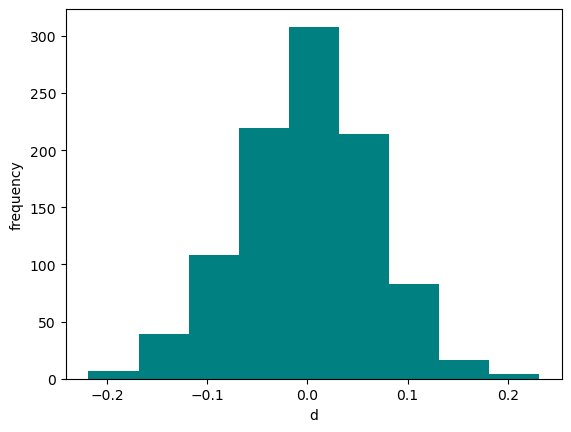

In [15]:
# Cohen's d denotes the size and direction of the difference between
# the two groups (opinion vs. no opinion). Note: These results are not
# reliable based on our very bad performing classifiers that we used to
# extract the variables and just for illustration purposes.
plt.hist(summary_d, bins=np.arange(np.min(summary_d), np.max(summary_d), 0.05), color='teal')
plt.xlabel('d')
plt.ylabel('frequency')